## Submission for BHI 2023 Public Health Informatics Data Competition
*CAN US aggregate timeseries dataset*

#### Imports

In [165]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

#### Load Dataframes & Sub-set Data

In [166]:
df = pd.read_csv("../data/US.timeseries.csv", usecols=["date", "actuals.newCases", "metrics.testPositivityRatio"], index_col="date", parse_dates=True)

df = df.fillna(method="bfill")

df = df[df.index < '2021-10-03']

new_cases = pd.DataFrame(df['actuals.newCases'])
pos_ratio = pd.DataFrame(df['metrics.testPositivityRatio'])

new_cases, pos_ratio

(            actuals.newCases
 date                        
 2020-03-09             403.0
 2020-03-10             403.0
 2020-03-11             403.0
 2020-03-12             403.0
 2020-03-13             542.0
 ...                      ...
 2021-09-28          113340.0
 2021-09-29          128470.0
 2021-09-30          115704.0
 2021-10-01          125584.0
 2021-10-02           44222.0
 
 [573 rows x 1 columns],
             metrics.testPositivityRatio
 date                                   
 2020-03-09                        0.128
 2020-03-10                        0.128
 2020-03-11                        0.128
 2020-03-12                        0.128
 2020-03-13                        0.128
 ...                                 ...
 2021-09-28                        0.061
 2021-09-29                        0.061
 2021-09-30                        0.061
 2021-10-01                        0.060
 2021-10-02                        0.063
 
 [573 rows x 1 columns])

#### Plot time-series

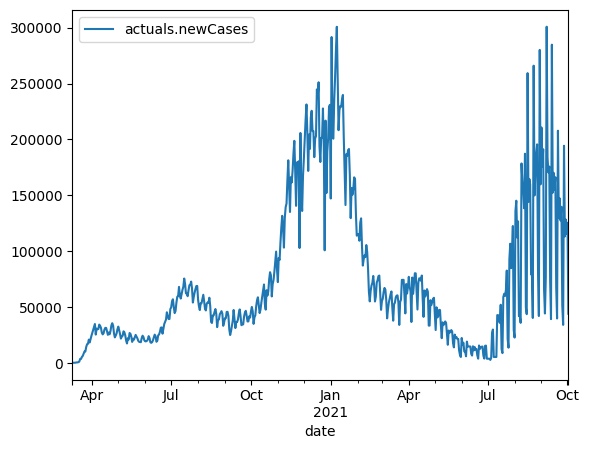

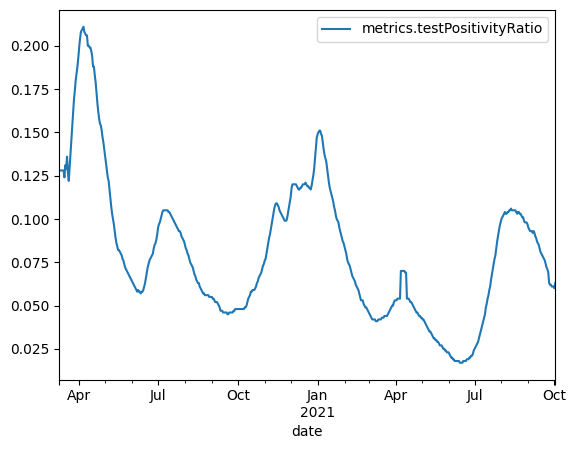

In [167]:
new_cases.plot()
plt.show()

pos_ratio.plot()
plt.show()

### Normalize New Case Data using MinMaxScaler

In [168]:
scaler_nc = MinMaxScaler(feature_range=(-1, 1))
scaler_pr = MinMaxScaler(feature_range=(-1, 1))

new_cases = scaler_nc.fit_transform(new_cases.values.reshape(-1, 1))
pos_ratio = scaler_pr.fit_transform(pos_ratio.values.reshape(-1, 1))

new_cases

array([[-1.00000000e+00],
       [-1.00000000e+00],
       [-1.00000000e+00],
       [-1.00000000e+00],
       [-9.99074641e-01],
       [-9.98202540e-01],
       [-9.98029452e-01],
       [-9.96651399e-01],
       [-9.93376029e-01],
       [-9.77485154e-01],
       [-9.77485154e-01],
       [-9.65775038e-01],
       [-9.59310841e-01],
       [-9.45949724e-01],
       [-9.33247677e-01],
       [-9.33247677e-01],
       [-9.06219210e-01],
       [-8.89635981e-01],
       [-8.87352542e-01],
       [-8.62481027e-01],
       [-8.79423748e-01],
       [-8.59818124e-01],
       [-8.40066040e-01],
       [-8.23456182e-01],
       [-8.04929034e-01],
       [-7.87553591e-01],
       [-7.69505765e-01],
       [-8.32430165e-01],
       [-7.96887066e-01],
       [-8.00781562e-01],
       [-7.99463425e-01],
       [-7.73080713e-01],
       [-7.80084148e-01],
       [-7.92207014e-01],
       [-8.21166085e-01],
       [-8.31151972e-01],
       [-8.25007323e-01],
       [-8.02938514e-01],
       [-7.9

### Look-back function

In [169]:
import numpy as np

# function to create train, test data given stock data and sequence length
def load_data(data_raw, look_back):
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data)
    test_set_size = 7
    train_set_size = data.shape[0] - test_set_size
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [torch.Tensor(x_train), torch.Tensor(y_train), torch.Tensor(x_test), torch.Tensor(y_test)]

look_back = 30 # choose sequence length

X_train_nc, y_train_nc, X_test_nc, y_test_nc = load_data(new_cases, look_back)
print('x_train.shape for new cases = ',X_train_nc.shape)
print('y_train.shape for new cases = ',y_train_nc.shape)
print('x_train.shape for new cases = ',X_test_nc.shape)
print('y_train.shape for new cases = ',y_test_nc.shape)

print("\n")

X_train_pr, y_train_pr, X_test_pr, y_test_pr = load_data(pos_ratio, look_back)
print('x_train.shape for positivity ratio = ',X_train_nc.shape)
print('y_train.shape for positivity ratio = ',y_train_nc.shape)
print('x_train.shape for positivity ratio = ',X_test_nc.shape)
print('y_train.shape for positivity ratio = ',y_test_nc.shape)


x_train.shape for new cases =  torch.Size([536, 29, 1])
y_train.shape for new cases =  torch.Size([536, 1])
x_train.shape for new cases =  torch.Size([7, 29, 1])
y_train.shape for new cases =  torch.Size([7, 1])


x_train.shape for positivity ratio =  torch.Size([536, 29, 1])
y_train.shape for positivity ratio =  torch.Size([536, 1])
x_train.shape for positivity ratio =  torch.Size([7, 29, 1])
y_train.shape for positivity ratio =  torch.Size([7, 1])


#### LTSM Neural Network Definition

In [170]:
import torch.nn as nn

mps = torch.device('mps')

# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(mps)
        
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = c0.to(mps)
        
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

#### Training Loop

Epoch 0 - MSE: 0.3855770528316498
Epoch 10 - MSE: 0.11897001415491104
Epoch 20 - MSE: 0.04249073565006256
Epoch 30 - MSE: 0.04167645424604416
Epoch 40 - MSE: 0.040515899658203125
Epoch 50 - MSE: 0.03932100906968117
Epoch 60 - MSE: 0.03853726014494896
Epoch 70 - MSE: 0.03815314918756485
Epoch 80 - MSE: 0.03783474490046501
Epoch 90 - MSE: 0.03749033063650131
Epoch 100 - MSE: 0.03706939518451691


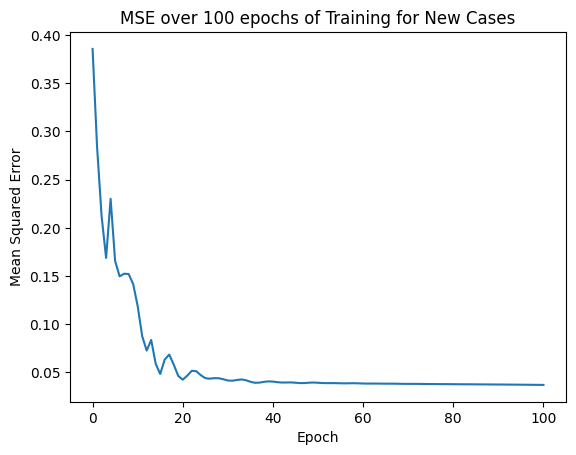

Epoch 0 - MSE: 0.43889907002449036
Epoch 10 - MSE: 0.10466530919075012
Epoch 20 - MSE: 0.0217449888586998
Epoch 30 - MSE: 0.007035890128463507
Epoch 40 - MSE: 0.002905762754380703
Epoch 50 - MSE: 0.0024262911174446344
Epoch 60 - MSE: 0.0017036263598129153
Epoch 70 - MSE: 0.0012337416410446167
Epoch 80 - MSE: 0.0010071765864267945
Epoch 90 - MSE: 0.0008159457356669009
Epoch 100 - MSE: 0.0006851815269328654


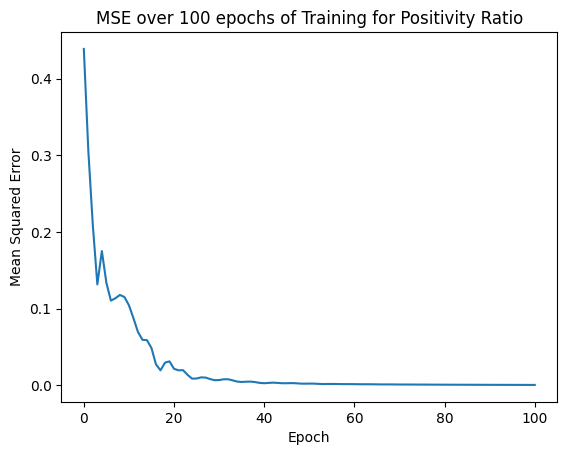

In [171]:

import numpy as np
import torch.optim as optim
import torch.utils.data as data

## New Cases
X_train_nc = X_train_nc.to(mps)
y_train_nc = y_train_nc.to(mps)

X_test_nc = X_test_nc.to(mps)
y_test_nc = y_test_nc.to(mps)


## Positivity Ratio
X_train_pr = X_train_pr.to(mps)
y_train_pr = y_train_pr.to(mps)

X_test_pr = X_test_pr.to(mps)
y_test_pr = y_test_pr.to(mps)
    
def train(X_train, y_train, hidden_dims, num_layers, n_epochs, lr):
    
    model = LSTM(input_dim=1, hidden_dim=hidden_dims, output_dim=1, num_layers=num_layers)

    model.to(mps)

    optimizer = optim.Adam(model.parameters(), lr)
    loss_fn = nn.MSELoss()
    
    hist = np.zeros(n_epochs)
    
    for epoch in range(n_epochs):
        model.train()
        
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        hist[epoch] = loss.item()
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch} - MSE: {loss.item()}")
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Validation
        
    return hist, model

hist_nc, model_nc = train(X_train_nc, y_train_nc, 32, 2, 101, 0.01)
plt.title("MSE over 100 epochs of Training for New Cases")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.plot(hist_nc)
plt.show()

hist_pr, model_pr = train(X_train_pr, y_train_pr, 32, 2, 101, 0.01)
plt.title("MSE over 100 epochs of Training for Positivity Ratio")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.plot(hist_pr)
plt.show()

### Evaluation function to calculate RSME & MAE

In [172]:
def test(model, X_train, y_train, X_test, y_test, scaler):
    with torch.no_grad():
        y_train_pred = model(X_train)
        y_test_pred = model(X_test)
        
        y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu())[:, 0]
        y_train_real = scaler.inverse_transform(y_train.detach().cpu())[:, 0]
        y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu())[:, 0]
        y_test_real = scaler.inverse_transform(y_test.detach().cpu())[:, 0]
        
        train_rsme = np.sqrt(mean_squared_error(y_train_real, y_train_pred))
        train_mae = np.mean(abs(y_train_pred - y_train_real))
        test_rsme = np.sqrt(mean_squared_error(y_test_real, y_test_pred))
        test_mae = np.mean(abs(y_test_pred - y_test_real))
            
        print(f"Train RSME: {train_rsme}, Train MAE: {train_mae}, Test RSME: {test_rsme}, Test MAE: {test_mae}")
        
        return [y_train_pred, y_train_real, y_test_pred, y_test_real, train_rsme, train_mae, test_rsme, test_mae]
    
nc_results = test(model_nc, X_train_nc, y_train_nc, X_test_nc, y_test_nc, scaler_nc)
pr_results = test(model_pr, X_train_pr, y_train_pr, X_test_pr, y_test_pr, scaler_pr)

Train RSME: 28900.48869714775, Train MAE: 15836.711627300669, Test RSME: 56970.58820653652, Test MAE: 40332.86661243439
Train RSME: 0.0025229080909692633, Train MAE: 0.0017622745566699069, Test RSME: 0.0034391178618584663, Test MAE: 0.0023932721189090203


### Historical Predictions for 8/30/2021 - 9/26/2021

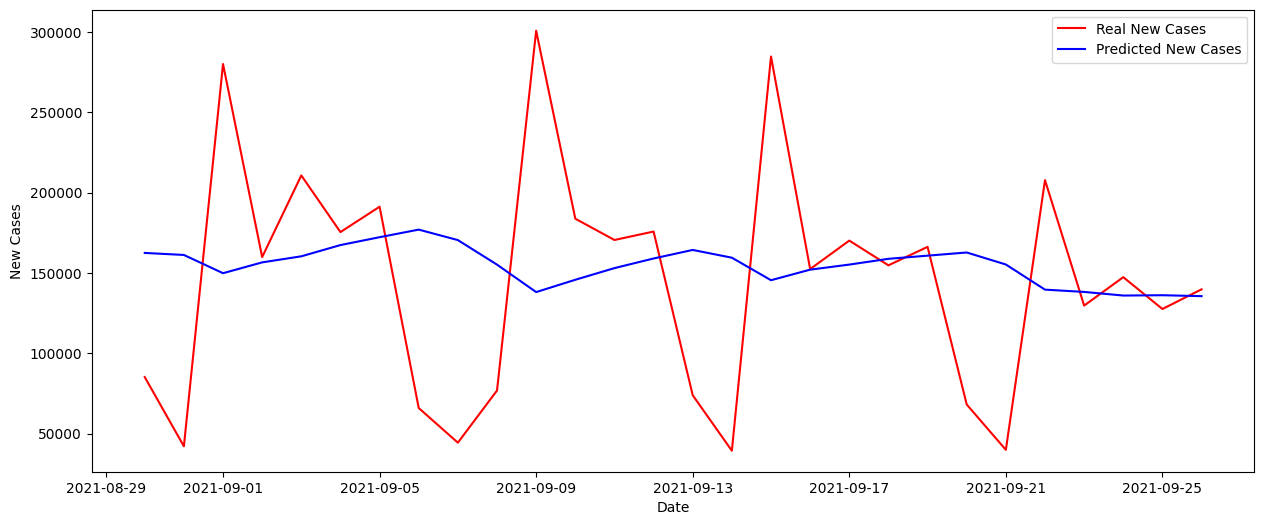

8/30/21 - 9/26/21: RSME - 28900.48869714775, MAE 15836.711627300669


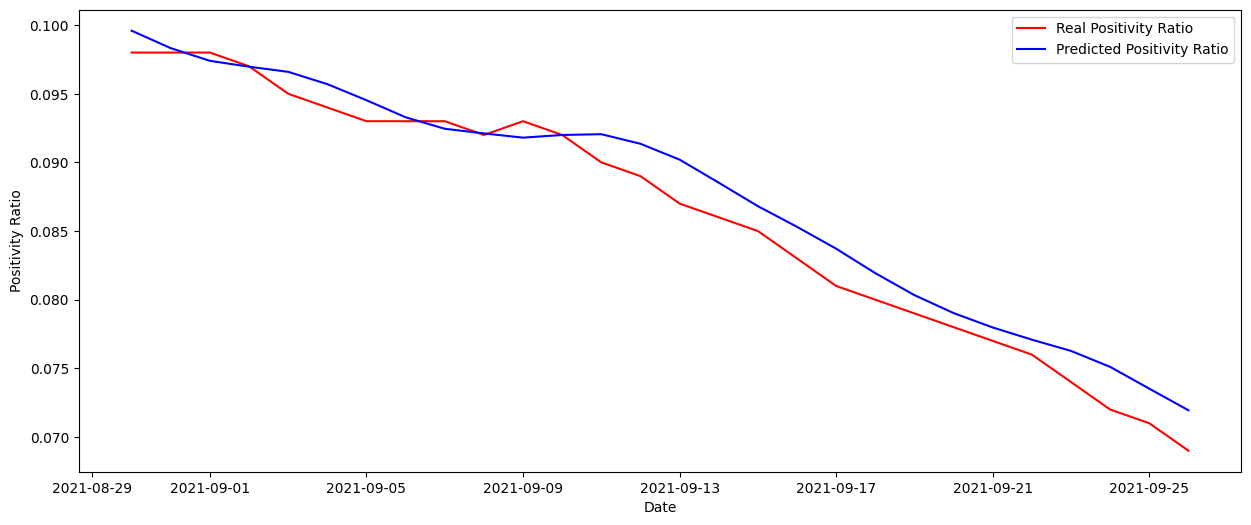

8/30/21 - 9/26/21: RSME - 0.0025229080909692633, MAE 0.0017622745566699069


In [173]:
def plot(y_train_pred, y_train_real, y_test_pred, y_test_real, train_rsme, train_mae, test_rsme, test_mae, label, train=True):
  figure, axes = plt.subplots(figsize=(15, 6))
  axes.xaxis_date()


  df_hist = None
  
  if train:
    df_hist = df.loc['2021-08-30':'2021-09-26']
  else:
    df_hist = df.loc['2021-09-27':'2021-10-03']
  
  
  y_train_real_hist = y_train_real[len(y_train_real) - len(df_hist):]
  y_train_pred_hist = y_train_pred[len(y_train_pred) - len(df_hist):]
  
  y_test_real_hist = y_test_real[len(y_test_real) - len(df_hist):]
  y_test_pred_hist = y_test_pred[len(y_test_pred) - len(df_hist):]

  axes.plot(df_hist.index, y_train_real_hist if train else y_test_real_hist, color = 'red', label = f'Real {label}')
  axes.plot(df_hist.index, y_train_pred_hist if train else y_test_pred_hist, color = 'blue', label = f'Predicted {label}')
  
  
  axes.set_xlabel("Date")
  axes.set_ylabel(f"{label}")

  plt.legend()
  plt.show()

  print(f"8/30/21 - 9/26/21: RSME - {train_rsme}, MAE {train_mae}")

# unpack into historical predictions function
plot(*nc_results, label="New Cases")
plot(*pr_results, label="Positivity Ratio")

### Plots for 9/27/21 - 10/03/21

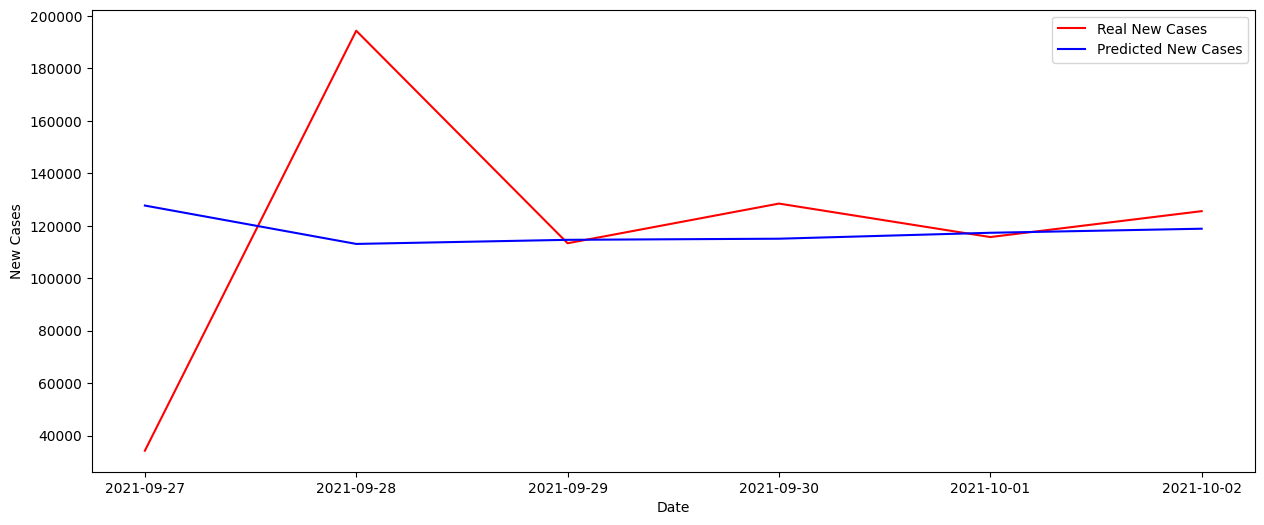

8/30/21 - 9/26/21: RSME - 28900.48869714775, MAE 15836.711627300669


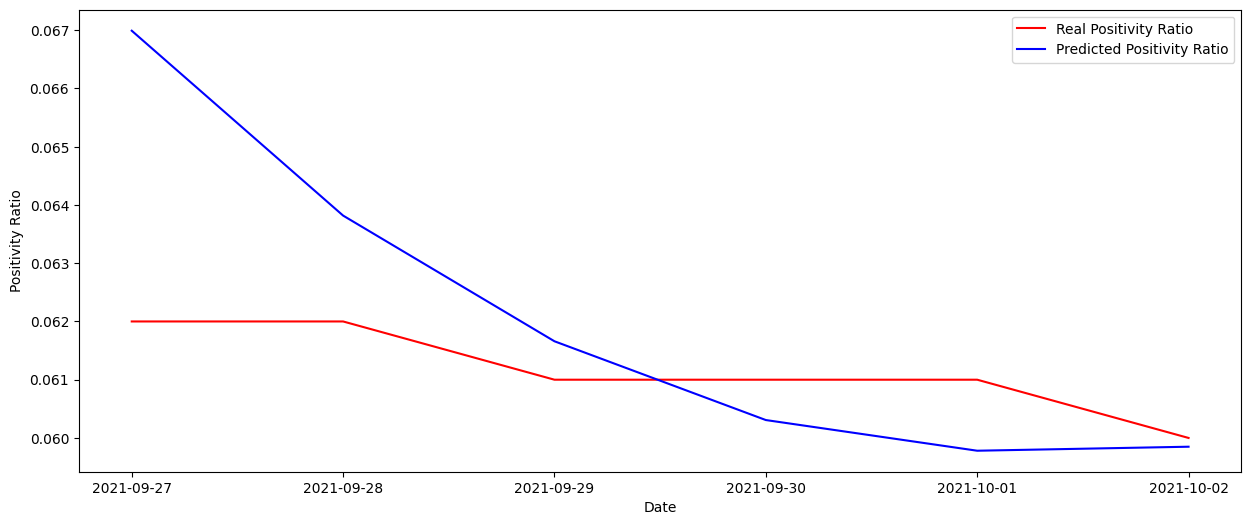

8/30/21 - 9/26/21: RSME - 0.0025229080909692633, MAE 0.0017622745566699069


In [187]:
plot(*nc_results, label="New Cases", train=False)
plot(*pr_results, label="Positivity Ratio", train=False)

### Predictions for 9/27/21 - 10/03/21

In [193]:
preds = pd.DataFrame()
preds["date"] = pd.date_range("2021-09-27", "2021-10-03")
preds = preds.set_index("date")

for result in [(nc_results, "new_cases"), (pr_results, "pos_ratio")]:
  metrics, name = result
  y_train_pred, y_train_real, y_test_pred, y_test_real, train_rsme, train_mae, test_rsme, test_mae = metrics
  
  preds[f"{name}_pred"] = y_test_pred
  
  sev_avg_pred = np.zeros(len(y_test_pred))
  sev_avg_real = np.zeros(len(y_test_real))
  
  for i in range(len(y_test_pred)):
    sev_avg_pred[i] = (y_train_pred[len(y_train_pred) - len(y_test_pred) + i + 1:].sum() + y_test_pred[:i + 1].sum()) / len(y_test_pred)
    sev_avg_real[i] = (y_train_real[len(y_train_real) - len(y_test_real) + i + 1:].sum() + y_test_real[:i + 1].sum()) / len(y_test_real)
  
  preds[f"7_day_avg_{name}_pred"] = sev_avg_pred
  # preds[f"7_day_avg_{name}_real"] = sev_avg_real
  
  # preds[f"7_day_avg_{name}_ae"] = preds[f"7_day_avg_{name}_pred"] - preds[f"7_day_avg_{name}_real"]
  
  # print(preds[f"7_day_avg_{name}_ae"].mean())
  
preds.to_csv("results.csv")
preds
  

,new_cases_pred,7_day_avg_new_cases_pred,pos_ratio_pred,7_day_avg_pos_ratio_pred
date,,,,
2021-09-27,136109.338280,139592.086932,0.070221,0.074589
2021-09-28,127717.833734,135649.034965,0.066992,0.073020
2021-09-29,113085.500261,131851.707445,0.063818,0.071124
2021-09-30,114649.549032,128480.633715,0.061660,0.069037
2021-10-01,115074.525693,125492.220956,0.060307,0.066923
2021-10-02,117337.630552,122798.959613,0.059781,0.064960
2021-10-03,118886.254969,120408.661789,0.059850,0.063233
